## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
total = df.shape[0]
print(total)

294478


c. The number of unique users in the dataset.

In [4]:
unique_users =df.user_id.nunique()
print(unique_users)

290584


d. The proportion of users converted.

In [5]:
por_conv = df.converted.sum() / total 
print(por_conv)

0.119659193556


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
cond1 = df.query('landing_page !="new_page" & group == "treatment"').shape[0]
cond2 = df.query('landing_page =="new_page" & group != "treatment"').shape[0]
number_nonmatches = cond1 + cond2
print(number_nonmatches)

3893


f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df1 = df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index)
df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.user_id.drop_duplicates(inplace= True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
prior = df2.converted.sum() / df2.shape[0]
print(prior)

0.119596675671


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control = df2.groupby('group').converted.mean()[0]
print(control)

0.1203863045


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment = df2.groupby('group').converted.mean()[1]
print(treatment)

0.118807247903


d. What is the probability that an individual received the new page?

In [17]:
new_page = df2.query('landing_page == "new_page"').shape[0] / len(df2)
print(new_page)

0.5000636646764286


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer**:<br>
*Control recieved only old pages, Treatment recieved only new pages. and both of them have 50% pre cent of happening. Then there are 11.88% of new treatment page converted compared to 12% of old control page converted. That leads to conclued that the new treatment page doesn't lead to more conversion*.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

* **Null hypothesis**:     <div style="text-align: justify"> **$p_{old}$** - **$p_{new}$** >= 0 </div> 
* **Alternative hypothesis**: <div style="text-align: justify"> **$p_{old}$** - **$p_{new}$** < 0 </div> 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.sum() / df2.shape[0]
print(p_new)

0.119596675671


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.sum() / df2.shape[0]
print(p_old)

0.119596675671


c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]
print(n_new)

145311


d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query('group == "control"').shape[0]
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
#new_page_converted = df2.sample(n_new,replace=True)['converted']
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.12063780443325006

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
#old_page_converted = df2.sample(n_old,replace=True)['converted']
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.11976678552252984

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
old_page_converted.mean()- new_page_converted.mean() 

-0.00087101891072022264

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10_000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
    p_diffs.append(old_page_converted - new_page_converted)

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

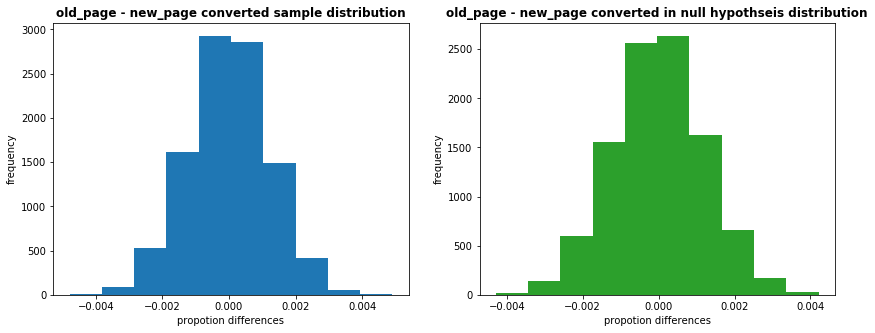

In [26]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1.hist(p_diffs)
ax1.set_xlabel('propotion differences')
ax1.set_ylabel('frequency')
ax1.set_title('old_page - new_page converted sample distribution',fontweight='bold');

ax2 = fig.add_subplot(122)
ax2.hist(np.random.normal(0,p_diffs.std(),10_000),color='tab:green')
ax2.set_xlabel('propotion differences')
ax2.set_ylabel('frequency')
ax2.set_title('old_page - new_page converted in null hypothseis distribution',fontweight='bold');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

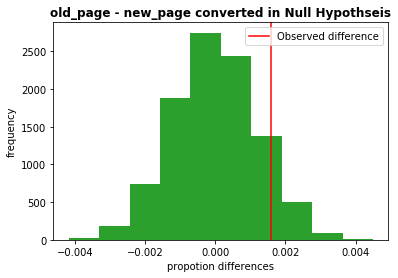

p-value: 0.9043


In [30]:
control = df2.query('group == "control"')
treatment = df2.query('group == "treatment"')
obs_diff = control.converted.mean() - treatment.converted.mean()
plt.hist(np.random.normal(0,p_diffs.std(),10_000),color='tab:green')
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.xlabel('propotion differences')
plt.ylabel('frequency')
plt.title('old_page - new_page converted in Null Hypothseis',fontweight='bold');
plt.legend()
plt.show()
print(f'p-value: {(obs_diff > p_diffs).mean()}')

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**<br>
*91% per cent of p_diffs is greater than the true observed diffs in dataset. This value is refering to the p-value. When p-value exceeded the significant value which is 5% we can't reject the null hypothesis. So, becasuse p-value exceeded the 5% we accept the null hypothesis.*

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
print(convert_old, convert_new, n_old, n_new, sep='\n')

17489
17264
145274
145311


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
zstat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)
zstat, p_value

(1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**<br>
*Both z-stat and p-value agree with j&k. p-value is 91% > 5% "significant value" means that we can't reject the null hypothesis. so, porpotion of newpage converted is gearter than goodpage converted*

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**<br>
*Logistic regression*

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df3 = df2.copy()
df3[['control','treatment']] = pd.get_dummies(df2['group'])
df3.rename(columns={'treatment': 'ab_page'},inplace=True)
df3.drop(columns=['control','landing_page'],axis = 1,inplace=True)
df3['intercept'] = 1
df3.head()

,user_id,timestamp,group,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
from scipy import stats
stats.chisqprob = lambda chisq, df3: stats.chi2.sf(chisq, df3)

model = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:               8.085e-06
Time:                        18:57:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:**<br>
In regression The **null hypothesis** is that variable in this model is **ab_page** has no correlation with dependant variable **converted**  statistically insignificant.
**Alternatvie hypothesis** is that variable has non-zero correlation changes in the response at the population level staistically  significant.
So, as the p-value of ab_page 0.19 is larger than the siginficant level 0.05 this means that this variable is statistically insignificant.<br>
In the A/B testing the null hypothesis is conversion in old pages is greater than conversion in new pages.The alternaive hypothesis is conversion in old pages is less than the conversion in new pages. The p-value associated with that test is 0.91 supporting the null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**<br>
It is good idea to consider other factors to add in regression model to find other features influence the model for better prediction.The disadvantage is the model becomes more complex.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('countries.csv')
df4 = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [37]:
df4.head()

,country,timestamp,group,converted,ab_page,intercept
user_id,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,0,1,1


In [38]:
df4.country.unique()

array(['US', 'UK', 'CA'], dtype=object)

In [39]:
df4[['US','UK','CA']]= pd.get_dummies(df4['country'])
df4.head()

,country,timestamp,group,converted,ab_page,intercept,US,UK,CA
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,0,1,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,1,1,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,0,0,1,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,0,1,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,0,1,1,0,0,1


In [40]:
df4['intercept'] = 1

lm = sm.Logit(df4['converted'],df4[['intercept','ab_page','US','UK']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:               2.324e-05
Time:                        18:58:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
df4['US_ab_page'] = df4.US * df4.ab_page
df4['CA_ab_page'] = df4.CA * df4.ab_page

df4['intercept'] = 1

lm = sm.Logit(df4['converted'],df4[['intercept','ab_page','US','US_ab_page','CA','CA_ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:               3.483e-05
Time:                        18:58:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
CA             0.0057      0.019      0.306      0.760      -0.031       0.043
CA_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

## Summary
> Looking to the summary above of the regression model. both interactions p-values are above the siginficant level which means that both are statistically insignificant. There are no effect of country name with state of pages on the conversion rate.

## Conclusion
> Based on Result in A/B testing and Resgression model.
* old_pages is statistically insignificant with conversion rate.
* Adding intersection "Country" with type of the page is also statistically insignificant to the converrdion rate. 

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0